## Introduction / Business Problem

Animal Crossing: New Horizons had a very prominent presence during the COVID-19 pandemic, and is one of the best-selling Switch games to this day. It had its period of glory, but is now a topic of controversy and debate surrounding Nintendo. I wanted to take on this dataset for analysis because I myself played Animal Crossing during the early days of the pandemic. It gave me something to do and I enjoyed it at the time, but I noticed that some people quickly became bored/burnt out with the lack of content, and I myself stopped playing after 9 months. I didn’t have the same experience as others, and because of that I want to know what the general populace thought of the game at the time by centering my project around Animal Crossing reviews.

If I were given the task to help Nintendo's dev team figure out new updates for New Horizons or help contribute ideas for the next title in the Animal Crossing series, I would want to look at reviews and feedback surrounding New Horizons to let them know what they did well and what they could improve on.

## Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb

from nltk.corpus import stopwords
from nltk import word_tokenize, regexp_tokenize, FreqDist
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud
import string
import re

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import plot_confusion_matrix, recall_score, f1_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline

In [2]:
user_df = pd.read_csv('data/user_reviews.csv')

user_df.head()

,grade,user_name,text,date
0,4,mds27272,My gf started playing before me. No option to ...,2020-03-20
1,5,lolo2178,"While the game itself is great, really relaxin...",2020-03-20
2,0,Roachant,My wife and I were looking forward to playing ...,2020-03-20
3,0,Houndf,We need equal values and opportunities for all...,2020-03-20
4,0,ProfessorFox,BEWARE! If you have multiple people in your h...,2020-03-20


Dropping `user_name` column so it's easier to focus on the most important information

In [3]:
user_df = user_df.drop(['user_name'], axis=1)
user_df.head()

,grade,text,date
0,4,My gf started playing before me. No option to ...,2020-03-20
1,5,"While the game itself is great, really relaxin...",2020-03-20
2,0,My wife and I were looking forward to playing ...,2020-03-20
3,0,We need equal values and opportunities for all...,2020-03-20
4,0,BEWARE! If you have multiple people in your h...,2020-03-20


In [4]:
user_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2999 entries, 0 to 2998
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   grade   2999 non-null   int64 
 1   text    2999 non-null   object
 2   date    2999 non-null   object
dtypes: int64(1), object(2)
memory usage: 70.4+ KB


Scores among users are heavily polarized

<AxesSubplot:>

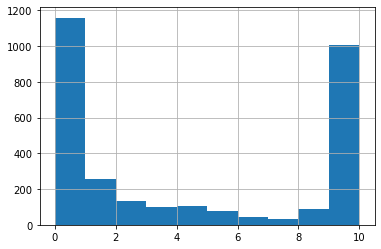

In [5]:
user_df['grade'].hist()

In [6]:
user_df['text']

0       My gf started playing before me. No option to ...
1       While the game itself is great, really relaxin...
2       My wife and I were looking forward to playing ...
3       We need equal values and opportunities for all...
4       BEWARE!  If you have multiple people in your h...
                              ...                        
2994    1 Island for console limitation.I cannot play ...
2995    Per giocare con figli o fidanzate, mogli o per...
2996    One island per console is a pathetic limitatio...
2997    Even though it seems like a great game with ma...
2998    Game is fantastic.Nintendo deciding that you c...
Name: text, Length: 2999, dtype: object

Tokenizing text

In [7]:
pattern = "([a-zA-Z]+(?:'[a-z]+)?)" # defining pattern so tokenizer recognizes apostrophes as one word

user_df['tokens_raw'] = [regexp_tokenize(text, pattern) for text in user_df['text']]

user_df['tokens_raw']

0       [My, gf, started, playing, before, me, No, opt...
1       [While, the, game, itself, is, great, really, ...
2       [My, wife, and, I, were, looking, forward, to,...
3       [We, need, equal, values, and, opportunities, ...
4       [BEWARE, If, you, have, multiple, people, in, ...
                              ...                        
2994    [Island, for, console, limitation, I, cannot, ...
2995    [Per, giocare, con, figli, o, fidanzate, mogli...
2996    [One, island, per, console, is, a, pathetic, l...
2997    [Even, though, it, seems, like, a, great, game...
2998    [Game, is, fantastic, Nintendo, deciding, that...
Name: tokens_raw, Length: 2999, dtype: object

Lowercasing text

In [8]:
user_df['tokens'] = user_df['tokens_raw'].apply(lambda x: [word.lower() for word in x])
user_df.head()

,grade,text,date,tokens_raw,tokens
0,4,My gf started playing before me. No option to ...,2020-03-20,"[My, gf, started, playing, before, me, No, opt...","[my, gf, started, playing, before, me, no, opt..."
1,5,"While the game itself is great, really relaxin...",2020-03-20,"[While, the, game, itself, is, great, really, ...","[while, the, game, itself, is, great, really, ..."
2,0,My wife and I were looking forward to playing ...,2020-03-20,"[My, wife, and, I, were, looking, forward, to,...","[my, wife, and, i, were, looking, forward, to,..."
3,0,We need equal values and opportunities for all...,2020-03-20,"[We, need, equal, values, and, opportunities, ...","[we, need, equal, values, and, opportunities, ..."
4,0,BEWARE! If you have multiple people in your h...,2020-03-20,"[BEWARE, If, you, have, multiple, people, in, ...","[beware, if, you, have, multiple, people, in, ..."


Removing stopwords

In [9]:
stopwords_list = stopwords.words('english')
stopwords_list += list(string.punctuation)
stopwords_list += ['game', 'animal', 'crossing']
user_df['no_stops'] = user_df['tokens'].apply(lambda x: [w for w in x if w not in stopwords_list])

user_df.head()

,grade,text,date,tokens_raw,tokens,no_stops
0,4,My gf started playing before me. No option to ...,2020-03-20,"[My, gf, started, playing, before, me, No, opt...","[my, gf, started, playing, before, me, no, opt...","[gf, started, playing, option, create, island,..."
1,5,"While the game itself is great, really relaxin...",2020-03-20,"[While, the, game, itself, is, great, really, ...","[while, the, game, itself, is, great, really, ...","[great, really, relaxing, gorgeous, can't, ign..."
2,0,My wife and I were looking forward to playing ...,2020-03-20,"[My, wife, and, I, were, looking, forward, to,...","[my, wife, and, i, were, looking, forward, to,...","[wife, looking, forward, playing, released, bo..."
3,0,We need equal values and opportunities for all...,2020-03-20,"[We, need, equal, values, and, opportunities, ...","[we, need, equal, values, and, opportunities, ...","[need, equal, values, opportunities, players, ..."
4,0,BEWARE! If you have multiple people in your h...,2020-03-20,"[BEWARE, If, you, have, multiple, people, in, ...","[beware, if, you, have, multiple, people, in, ...","[beware, multiple, people, house, want, play, ..."


Creating frequency distribution of words among reviews

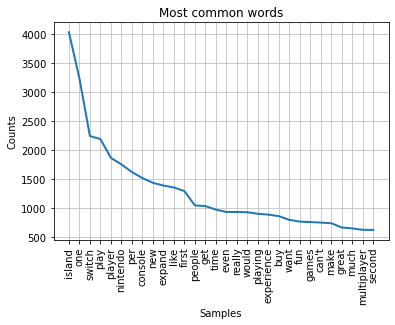

<AxesSubplot:title={'center':'Most common words'}, xlabel='Samples', ylabel='Counts'>

In [10]:
# for token_list in user_df['no_stops']:
#     token_list = ' '.join(token_list)
#     token_list = token_list.split(' ')
test = user_df.no_stops.explode().to_list()
fdist = FreqDist(test)
fdist.plot(30, title='Most common words')

# # user_freqdist = FreqDist(user_df['tokens_raw'])
# # user_freqdist.most_common(50)

Assigning "positive" and "negative" labels to data based on score threshold defined on Metacritic's review page for this game. For reference:
- 8-10 is "positive"
- 5-7 is "neutral"
- 0-4 is "negative"

https://www.metacritic.com/game/switch/animal-crossing-new-horizons/user-reviews

In [11]:
def sentiment_labels(row):
    if row['grade'] >= 8:
        val = 'positive'
    elif row['grade'] <= 4:
        val = 'negative'
    else:
        val = 'neutral'
    return val

In [12]:
user_df['sentiment'] = user_df.apply(sentiment_labels, axis=1)
user_df

,grade,text,date,tokens_raw,tokens,no_stops,sentiment
0,4,My gf started playing before me. No option to ...,2020-03-20,"[My, gf, started, playing, before, me, No, opt...","[my, gf, started, playing, before, me, no, opt...","[gf, started, playing, option, create, island,...",negative
1,5,"While the game itself is great, really relaxin...",2020-03-20,"[While, the, game, itself, is, great, really, ...","[while, the, game, itself, is, great, really, ...","[great, really, relaxing, gorgeous, can't, ign...",neutral
2,0,My wife and I were looking forward to playing ...,2020-03-20,"[My, wife, and, I, were, looking, forward, to,...","[my, wife, and, i, were, looking, forward, to,...","[wife, looking, forward, playing, released, bo...",negative
3,0,We need equal values and opportunities for all...,2020-03-20,"[We, need, equal, values, and, opportunities, ...","[we, need, equal, values, and, opportunities, ...","[need, equal, values, opportunities, players, ...",negative
4,0,BEWARE! If you have multiple people in your h...,2020-03-20,"[BEWARE, If, you, have, multiple, people, in, ...","[beware, if, you, have, multiple, people, in, ...","[beware, multiple, people, house, want, play, ...",negative
...,...,...,...,...,...,...,...
2994,1,1 Island for console limitation.I cannot play ...,2020-05-03,"[Island, for, console, limitation, I, cannot, ...","[island, for, console, limitation, i, cannot, ...","[island, console, limitation, cannot, play, gi...",negative
2995,1,"Per giocare con figli o fidanzate, mogli o per...",2020-05-03,"[Per, giocare, con, figli, o, fidanzate, mogli...","[per, giocare, con, figli, o, fidanzate, mogli...","[per, giocare, con, figli, fidanzate, mogli, p...",negative
2996,0,One island per console is a pathetic limitatio...,2020-05-03,"[One, island, per, console, is, a, pathetic, l...","[one, island, per, console, is, a, pathetic, l...","[one, island, per, console, pathetic, limitati...",negative
2997,2,Even though it seems like a great game with ma...,2020-05-03,"[Even, though, it, seems, like, a, great, game...","[even, though, it, seems, like, a, great, game...","[even, though, seems, like, great, many, items...",negative


Investigating class balance

In [13]:
user_df['sentiment'].value_counts()

negative    1747
positive    1096
neutral      156
Name: sentiment, dtype: int64

In [14]:
user_df['sentiment'].value_counts(normalize=True)

negative    0.582528
positive    0.365455
neutral     0.052017
Name: sentiment, dtype: float64

Significant class imbalance, there are far more negative reviews than positive/neutral.

<AxesSubplot:>

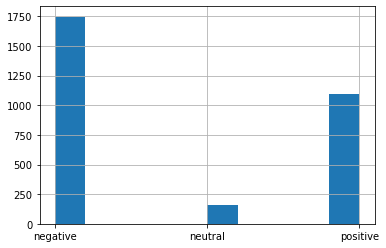

In [15]:
user_df['sentiment'].hist()

## Preprocessing

Lemmatizing words

In [16]:
lemmatizer = WordNetLemmatizer()
user_df['lemmatized'] = user_df['no_stops'].apply(lambda x:[lemmatizer.lemmatize(w) for w in x])
user_df['lemmatized']

0       [gf, started, playing, option, create, island,...
1       [great, really, relaxing, gorgeous, can't, ign...
2       [wife, looking, forward, playing, released, bo...
3       [need, equal, value, opportunity, player, isla...
4       [beware, multiple, people, house, want, play, ...
                              ...                        
2994    [island, console, limitation, cannot, play, gi...
2995    [per, giocare, con, figli, fidanzate, mogli, p...
2996    [one, island, per, console, pathetic, limitati...
2997    [even, though, seems, like, great, many, item,...
2998    [fantastic, nintendo, deciding, make, one, isl...
Name: lemmatized, Length: 2999, dtype: object

Training and test set split

In [17]:
X = user_df['lemmatized'].str.join(' ')
y = user_df['sentiment']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

## Analysis

- TF-IDF vectorizer to convert our text data into binary vectors that our classifiers can process
- Because our categories are imbalanced, to prevent overfitting we resample our data using SMOTE and define a sampling strategy to ensure SMOTE resamples all classes except our majority class
- Pipeline is created to prevent data leakage

In [18]:
def text_classification(model):
    """
    Takes in a scikit-learn classifier and runs a model
    based on the training data provided. Returns cross-validated
    scores and an average score rating the performance of the model.
    Also returns a confusion matrix as a visual representation
    of the model's accuracy.
    """
    tfidf_vectorizer = TfidfVectorizer()
    smote = SMOTE(sampling_strategy='not majority')
    
    pipeline = make_pipeline(tfidf_vectorizer, smote, model)
    
    scores = cross_val_score(pipeline, X_train, y_train)
    print('Cross-validated scores:', scores)
    print('Average score:', np.mean(scores))
    
    pipeline.fit(X_train, y_train)
    plot_confusion_matrix(pipeline, X_test, y_test)

First model is simple machine learning model, logistic regression model

Cross-validated scores: [0.8375     0.83333333 0.79791667 0.8125     0.82045929]
Average score: 0.8203418580375782


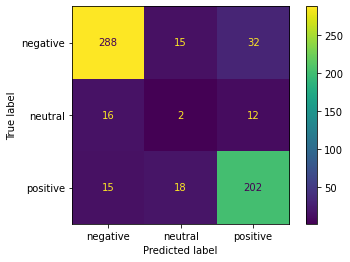

In [19]:
logreg_model = LogisticRegression()
logreg_pipe = text_classification(logreg_model)

Next model is Naive Bayes, goes off of statistical Bayes' theorem. There are multiple iterations of the Naive Bayes classifier, multinomial Naive Bayes is the most suitable for text classification

Cross-validated scores: [0.68333333 0.69583333 0.67083333 0.73541667 0.71398747]
Average score: 0.6998808281141267


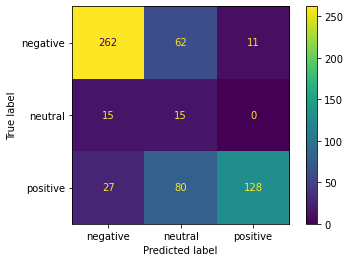

In [20]:
mnb_model = MultinomialNB()
text_classification(mnb_model)

Decision tree classifier
- Another simple classifier that revolves around the idea of predicting the value of a target variable using decision rules inferred from the data features. The concept of this model matches well with the idea behind our model (using key words to predict the sentiment of a review)

https://scikit-learn.org/stable/modules/tree.html

Cross-validated scores: [0.6625     0.63333333 0.59375    0.67916667 0.65553236]
Average score: 0.6448564718162839


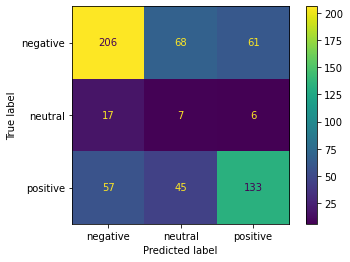

In [21]:
dt_model = DecisionTreeClassifier(max_depth=5)
text_classification(dt_model)

Random forest classifier (averaged ensemble of decision trees). Did better than decision tree model, however is not as good as logreg model.
- Ensemble method; derives from decision tree classifier. Unlike decision tree classifier, which creates a tree from the whole dataset, random forest takes subsets of the training set to create individual trees and averages all the trees to produce the most optimal predictive ability.

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

Cross-validated scores: [0.78333333 0.80416667 0.7875     0.84375    0.82254697]
Average score: 0.808259394572025


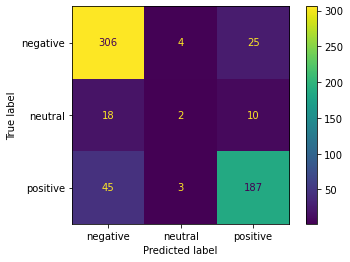

In [22]:
rf_model = RandomForestClassifier()
text_classification(rf_model)